In [18]:
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import itertools

In [2]:
def deserialize_matrix(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        matrix = []
        for l in lines:
            l = l.strip()
            l = l.replace(' ', '')
            tokens = l.split(',')
            row = [float(el) for el in tokens if el != "" and el != " "]
            matrix.append(row)
    return np.asarray(matrix)

In [3]:
def deserialize_id_map(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        idmap = dict()
        for l in lines:
            tokens = l.split(",")
            col_id = int(tokens[0])
            col_name = tokens[1].strip()
            idmap[col_id] = col_name
    return idmap

In [4]:
def name_pair(pair, idmap):
    i, j = pair
    return idmap[i] + " ~ " + idmap[j]

In [15]:
def compute_theta(matrix):
    theta_matrix = []
    for row in matrix:
        aggr_jc = sum(row)
        total_d = len(row)
        if aggr_jc > 0:
            beta = math.log((total_d/aggr_jc))
            theta_row = []
            for jc in row:
                theta = (jc * beta) / math.log(total_d)
                theta_row.append(theta)
        else:
            theta_row = [0 for jc in row]
        theta_matrix.append(theta_row)
    return np.asarray(theta_matrix)

In [13]:
ngrams = [2,3,4,5,6]
input_matrices = []
input_idmaps = []
for n in ngrams:
    input_matrix = "temp/mit_matrix_n{}_k64.dat".format(n)
    input_idmap = "temp/mit_matrix_n{}_k64.dat_nameMap".format(n)
    input_matrices.append(input_matrix)
    input_idmaps.append(input_idmap)

In [23]:
jc_matrices = dict()
th_matrices = dict()
n_idmap = dict()
for idx, path in enumerate(input_matrices):
    jc_matrix = deserialize_matrix(path)
    th_matrix = compute_theta(jc_matrix)
    n = idx + 2
    jc_matrices[n] = jc_matrix
    th_matrices[n] = th_matrix
    # idmap
    im = deserialize_id_map(input_idmaps[idx])
    n_idmap[n] = im

## Plotting diff between theta and JC for different N

In [26]:
def measure_diff(jc_matrix, theta_matrix):    
    diffs = []
    for i, j in itertools.product([x for x in range(jc_matrix.shape[0])], [x for x in range(jc_matrix.shape[0])]):
        # ONLY COUNT NON-ZERO
        if jc_matrix[i][j] > 0:
            diff = jc_matrix[i][j] - theta_matrix[i][j]
            diffs.append(diff)
    diffs = np.asarray(diffs)
    max_diff = np.max(diffs)
    min_diff = np.min(diffs)
    med_diff = np.percentile(diffs, 50)
    p95_diff = np.percentile(diffs, 95)
    p25_diff = np.percentile(diffs, 25)
    p90_diff = np.percentile(diffs, 90)
    p5_diff = np.percentile(diffs, 5)
    p75_diff = np.percentile(diffs, 75)
    p85_diff = np.percentile(diffs, 85)
    avg_diff = np.average(diffs)
    print("Max-diff: " + str(max_diff))
    print("min-diff: " + str(min_diff))
    print("avg: " + str(avg_diff))
    print("p5: " + str(p5_diff))
    print("p25: " + str(p25_diff))
    print("median: " + str(med_diff))
    print("p75: " + str(p75_diff))
    print("p85: " + str(p85_diff))
    print("p90: " + str(p90_diff))
    print("p95: " + str(p95_diff))

In [27]:
ngrams = [2,3,4,5,6]
for n in ngrams:
    print("N-GRAM: " + str(n))
    jc_matrix = jc_matrices[n]
    th_matrix = th_matrices[n]
    measure_diff(jc_matrix, th_matrix)

N-GRAM: 2
Max-diff: 0.8275879767398286
min-diff: -0.0017266819891763596
avg: 0.3231151660891969
p5: 0.0757316684008584
p25: 0.12624784194876765
median: 0.26179260480984234
p75: 0.4858193135266591
p85: 0.6122401335965182
p90: 0.6753463256387479
p95: 0.7507212539236987
N-GRAM: 3
Max-diff: 0.5988990542841042
min-diff: -0.0017266819891763596
avg: 0.1628432051333763
p5: 0.03613243547338996
p25: 0.06808403616108256
median: 0.11240318786214597
p75: 0.22072367672027307
p85: 0.3107261999837635
p90: 0.37623199915516103
p95: 0.4588343699957961
N-GRAM: 4
Max-diff: 0.5326875709936391
min-diff: -0.0017266819891763596
avg: 0.16903250284003465
p5: 0.018783179415675345
p25: 0.05947435900054751
median: 0.12071941027349276
p75: 0.25655024004934956
p85: 0.34074562762618976
p90: 0.39161224388744753
p95: 0.4268199477966632
N-GRAM: 5
Max-diff: 0.5308315100588523
min-diff: -0.0017266819891763596
avg: 0.2055155544435756
p5: 0.007287740368301508
p25: 0.058413067290561546
median: 0.15924945301765567
p75: 0.31144

## Number of JC candidates vs TH candidates

In [29]:
def candidates(matrix, threshold):
    pairs = []
    for i, row in enumerate(matrix):
        for j, el in enumerate(row):
            if el > threshold and i != j:
                pairs.append((i, j))
    return pairs

In [34]:
ngrams = [2,3,4,5,6]
jc_data = []
th_data = []
for n in ngrams:
    print("")
    print("N-GRAM: " + str(n))
    print("")
    jc_matrix = jc_matrices[n]
    th_matrix = th_matrices[n]
    jcs = []
    ths = []
    for th in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        jc_pairs = candidates(jc_matrix, th)  # not counting i,i
        th_pairs = candidates(th_matrix, th)
        print("Threshold: " + str(th))
        print("JC: " + str(len(jc_pairs)))
        print("TH: " + str(len(th_pairs)))
        jcs.append(len(jc_pairs))
        ths.append(len(th_pairs))
    jc_data.append(jcs)
    th_data.append(ths)


N-GRAM: 2

Threshold: 0.1
JC: 281640
TH: 167384
Threshold: 0.2
JC: 215534
TH: 59686
Threshold: 0.3
JC: 176982
TH: 15851
Threshold: 0.4
JC: 140718
TH: 4545
Threshold: 0.5
JC: 111394
TH: 2072
Threshold: 0.6
JC: 88787
TH: 1021
Threshold: 0.7
JC: 67744
TH: 453
Threshold: 0.8
JC: 50823
TH: 170
Threshold: 0.9
JC: 33489
TH: 14

N-GRAM: 3

Threshold: 0.1
JC: 37246
TH: 32620
Threshold: 0.2
JC: 26800
TH: 16076
Threshold: 0.3
JC: 17618
TH: 10528
Threshold: 0.4
JC: 13339
TH: 6986
Threshold: 0.5
JC: 10468
TH: 4133
Threshold: 0.6
JC: 8498
TH: 1821
Threshold: 0.7
JC: 6724
TH: 740
Threshold: 0.8
JC: 5703
TH: 324
Threshold: 0.9
JC: 4559
TH: 21

N-GRAM: 4

Threshold: 0.1
JC: 18060
TH: 16403
Threshold: 0.2
JC: 13390
TH: 10216
Threshold: 0.3
JC: 10352
TH: 7490
Threshold: 0.4
JC: 8441
TH: 5866
Threshold: 0.5
JC: 7124
TH: 4183
Threshold: 0.6
JC: 6085
TH: 2100
Threshold: 0.7
JC: 5412
TH: 1047
Threshold: 0.8
JC: 4612
TH: 446
Threshold: 0.9
JC: 3924
TH: 57

N-GRAM: 5

Threshold: 0.1
JC: 8376
TH: 8308
Threshol

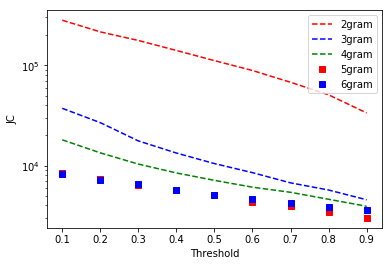

In [43]:
fig, ax = plt.subplots()
# plt.ylim((0, 1))
# plt.xlim((0, 1))
ax.set_xlabel("Threshold")
ax.set_ylabel("JC")
ax.set_yscale('log')
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ax.plot(thresholds, jc_data[0], 'r--',  thresholds, jc_data[1], 'b--', thresholds, jc_data[2], 'g--', thresholds, jc_data[3], 'rs', thresholds, jc_data[4], 'bs')
ax.legend(['2gram', '3gram', '4gram', '5gram', '6gram'])

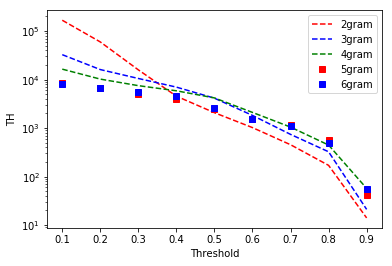

In [44]:
fig, ax = plt.subplots()
# plt.ylim((0, 1))
# plt.xlim((0, 1))
ax.set_xlabel("Threshold")
ax.set_ylabel("TH")
ax.set_yscale('log')
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ax.plot(thresholds, th_data[0], 'r--',  thresholds, th_data[1], 'b--', thresholds, th_data[2], 'g--', thresholds, th_data[3], 'rs', thresholds, th_data[4], 'bs')
ax.legend(['2gram', '3gram', '4gram', '5gram', '6gram'])

## Explore some examples manually

In [57]:
jc_pairs = candidates(jc_matrices[6], 0.9)
names = [name_pair(el, n_idmap[6]) for el in jc_pairs[0:4]]
names

['All_olap_descriptor_types.csv->Descriptor Type ~ All_olap_descriptor_types_2.csv->Descriptor Type',
 'Hr_org_unit_new.csv->Hr Org Level2 Name ~ Hr_org_unit_new.csv->Org Hier School Area Name',
 'Hr_org_unit_new.csv->Hr Org Level2 Name ~ Hr_org_unit.csv->Org Hier School Area Name',
 'Hr_org_unit_new.csv->Hr Org Level2 Name ~ Hr_org_unit.csv->Org Hier Top Level Name']

In [58]:
th_pairs = candidates(th_matrices[6], 0.9)
names = [name_pair(el, n_idmap[6]) for el in th_pairs[0:4]]
names

['Sdo_units_of_measure.csv->Target Uom Id ~ Sdo_units_of_measure.csv->Uom Id',
 'Master_dept_hierarchy.csv->Master Dept Hier Level 3 Code ~ Master_dept_dcode_parent.csv->Parent D Code',
 'Sdo_available_elem_ops.csv->Coord Op Id ~ Sdo_available_ops.csv->Coord Op Id',
 'All_olap_columns.csv->Owner ~ All_olap_tables.csv->Owner']

#### finding names like 'Last Name' of 'Warehouse_users.csv'

#### N = 2

In [73]:
for k, v in n_idmap[2].items():
    tokens = v.split("->")
    table = tokens[0].strip()
    attr = tokens[1].strip()
    if table == "Warehouse_users.csv" and attr == "Last Name":
        print(k)

496


In [74]:
n_idmap[2][496]

'Warehouse_users.csv->Last Name'

In [81]:
id_jc = dict()
for idx, el in enumerate(jc_matrices[2][496]):
    if el > 0:
        id_jc[idx] = el

In [83]:
print("Warehouse_users.csv -> Last Name containment to:")
for idx, jc in id_jc.items():
    print(n_idmap[2][idx] + " is: " + str(jc))

Warehouse_users.csv -> Last Name containment to:
Ir_institution.csv->City is: 0.85914457
Warehouse_users.csv->Last Name is: 0.9874631
Ir_institution.csv->Institution Name is: 1.0
Subject_attribute.csv->Subject Attribute Code is: 0.18141593


In [84]:
id_th = dict()
for idx, el in enumerate(th_matrices[2][496]):
    if el > 0:
        id_th[idx] = el

In [85]:
print("Warehouse_users.csv -> Last Name containment to:")
for idx, th in id_th.items():
    print(n_idmap[2][idx] + " is: " + str(th))

Warehouse_users.csv -> Last Name containment to:
Ir_institution.csv->City is: 0.7301168190017127
Warehouse_users.csv->Last Name is: 0.8391642601588811
Ir_institution.csv->Institution Name is: 0.8498183478034582
Subject_attribute.csv->Subject Attribute Code is: 0.15417058589782784


#### N = 4

In [86]:
for k, v in n_idmap[4].items():
    tokens = v.split("->")
    table = tokens[0].strip()
    attr = tokens[1].strip()
    if table == "Warehouse_users.csv" and attr == "Last Name":
        print(k)

496


In [87]:
n_idmap[4][496]

'Warehouse_users.csv->Last Name'

In [88]:
id_jc = dict()
for idx, el in enumerate(jc_matrices[4][496]):
    if el > 0:
        id_jc[idx] = el

In [89]:
print("Warehouse_users.csv -> Last Name containment to:")
for idx, jc in id_jc.items():
    print(n_idmap[4][idx] + " is: " + str(jc))

Warehouse_users.csv -> Last Name containment to:
short_course_catalog_subject_offered.csv->Fall Instructors is: 0.023802526
Field_dictionary_definition.csv->Field Name is: 0.15836866
Employee_directory.csv->Last Name is: 0.38056755
short_tip_subject_offered.csv->Responsible Faculty Name is: 0.104025856
Moira_list.csv->Moira List Name is: 1.0
short_subjects_offered.csv->Master Course Number Desc is: 0.012467991
Fields.csv->Field Name is: 0.14810461
Employee_directory.csv->Full Name is: 0.7326938
Roles_fin_pa.csv->Username is: 0.04344906
short_subjects_offered.csv->Course Number Desc is: 0.011670375
Tip_material.csv->Author is: 0.63389444
short_course_catalog_subject_offered.csv->Spring Instructors is: 0.023634609
Warehouse_users.csv->Krb Name Uppercase is: 0.7316654
Employee_directory.csv->Krb Name is: 0.60213673
Ir_institution.csv->City is: 0.34803325
Drupal_employee_directory.csv->Email Address is: 0.66626084
Employee_directory.csv->Email Address Uppercase is: 0.66401494
Employee_dire

In [92]:
# candidates at 4
len(id_jc)

55

In [90]:
id_th = dict()
for idx, el in enumerate(th_matrices[4][496]):
    if el > 0:
        id_th[idx] = el

In [91]:
print("Warehouse_users.csv -> Last Name containment to:")
for idx, th in id_th.items():
    print(n_idmap[4][idx] + " is: " + str(th))

Warehouse_users.csv -> Last Name containment to:
short_course_catalog_subject_offered.csv->Fall Instructors is: 0.013754266640399691
Field_dictionary_definition.csv->Field Name is: 0.09151317709401098
Employee_directory.csv->Last Name is: 0.2199105908920608
short_tip_subject_offered.csv->Responsible Faculty Name is: 0.060111240333056336
Moira_list.csv->Moira List Name is: 0.577849033350481
short_subjects_offered.csv->Master Course Number Desc is: 0.007204616547172496
Fields.csv->Field Name is: 0.08558210572324998
Employee_directory.csv->Full Name is: 0.4233864040718906
Roles_fin_pa.csv->Username is: 0.025106997320987045
short_subjects_offered.csv->Course Number Desc is: 0.006743714912587619
Tip_material.csv->Author is: 0.3662952894002445
short_course_catalog_subject_offered.csv->Spring Instructors is: 0.013657235964266578
Warehouse_users.csv->Krb Name Uppercase is: 0.42279214412599303
Employee_directory.csv->Krb Name is: 0.34794412737531955
Ir_institution.csv->City is: 0.20111067708632

In [93]:
# candidates at 4
len(id_th)

55